<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/MVTec_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [4]:
saved_model = load_model('/content/drive/My Drive/xai_model/MVTec_RN101_50_2.h5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import os
import cv2
import numpy as np
import keras.backend as K
from keras.layers import Conv2D

def read_batch(img_dir, batch_names, batch_sz, sz):
    img_batch = np.empty((batch_sz, sz[0], sz[1], 3), dtype='uint8')
    for i in range(batch_sz):
        tmp = cv2.imread(os.path.join(img_dir, batch_names[i]))
        img_batch[i] = cv2.resize(tmp, (sz[0], sz[1]))
    return img_batch

def get_grad_cam_weights(input_model, dummy_image, should_normalize=True):
    def find_final_layer(model):
        for iter_layer, layer in list(enumerate(model.layers)):
            if type(layer) == Conv2D:
                return model.layers[iter_layer].name
        raise Exception('Could not find the final layer in provided network')
    conv_layers = []
    for i in range(len(saved_model.layers)):
      if type(saved_model.layers[i]) == Conv2D:
        conv_layers.append(saved_model.layers[i].name)

    mid_layer_idx = len(conv_layers) / 2
    mid_layer = conv_layers[int(mid_layer_idx)]
    # final_layer = find_final_layer(input_model)
    conv_output = input_model.get_layer(mid_layer).output
    num_classes = input_model.output_shape[1]
    num_feats = int(conv_output.shape[-1])
    weights = np.zeros((num_feats, num_classes))

    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

    for iter_class in range(input_model.output_shape[1]):
        y_c = input_model.layers[-1].output[0, iter_class]
        if should_normalize:
            grad = normalize(K.gradients(y_c, conv_output)[0])
        else:
            grad = K.gradients(y_c, conv_output)[0]
        grad_func = K.function([input_model.layers[0].input, K.learning_phase()], [conv_output, grad])
        conv_val, grad_val = grad_func([dummy_image, 0])
        conv_val, grad_val = conv_val[0], grad_val[0]
        weights[:, iter_class] = np.mean(grad_val, axis=(0, 1))
    return weights, mid_layer

def grad_cam(input_model, weights, images, is_pass_threshold, final_layer, conf_scores, orig_sz=[224, 224],
             should_upsample=False):
    conv_output = input_model.get_layer(final_layer).output  # activation_7
    conv_func = K.function([input_model.layers[0].input], [conv_output])
    conv_val = conv_func([images])
    conv_val = conv_val[0]
    cams = np.einsum('ijkl,lm->ijkm', conv_val, weights)
    if should_upsample:
        old_cams = cams[:]
        cams = np.zeros((old_cams.shape[0], orig_sz[0], orig_sz[1], old_cams.shape[-1]))
        for i in range(cams.shape[0]):
            for j in range(cams.shape[-1]):
                # cams[i, :, :, j] = cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1]))
                cams[i, :, :, j] = np.maximum(cv2.resize(old_cams[i, :, :, j], (orig_sz[0], orig_sz[1])), 0)
    should_normalize = False
    if should_normalize:
        cams = cams / np.maximum(np.max(cams, axis=(1, 2, 3), keepdims=True), 1e-7)
        cams = cams * np.expand_dims(np.expand_dims(conf_scores * is_pass_threshold, axis=1), axis=2)
    else:
        cams = cams * np.expand_dims(np.expand_dims(is_pass_threshold, axis=1), axis=2)
    return cams

In [0]:
conv_layers = []
for i in range(len(saved_model.layers)):
  if type(saved_model.layers[i]) == Conv2D:
    conv_layers.append(saved_model.layers[i].name)

mid_layer_idx = len(conv_layers) / 2
mid_layer = conv_layers[int(mid_layer_idx)]

In [0]:
labels=  {'defective_bottle': 0, 'defective_cable': 1, 'defective_capsule': 2, 'defective_carpet': 3, 'defective_grid': 4, 'defective_hazelnut': 5, 'defective_leather': 6, 'defective_metalnut': 7, 'defective_pill': 8, 'defective_screw': 9, 'defective_tile': 10, 'defective_toothbrush': 11, 'defective_transistor': 12, 'defective_wood': 13, 'defective_zipper': 14, 'good_bottle': 15, 'good_cable': 16, 'good_capsule': 17, 'good_carpet': 18, 'good_grid': 19, 'good_hazelnut': 20, 'good_leather': 21, 'good_metalnut': 22, 'good_pill': 23, 'good_screw': 24, 'good_tile': 25, 'good_toothbrush': 26, 'good_transistor': 27, 'good_wood': 28, 'good_zipper': 29}

[[2.7506053e-08 8.3113694e-10 5.9861156e-09 1.7923078e-06 2.7277999e-08
  4.4620617e-07 9.9997663e-01 2.9068699e-08 5.5381211e-09 4.7696536e-09
  1.1290674e-07 3.4520660e-08 6.5420518e-09 1.1847858e-07 2.4101073e-06
  5.4501992e-10 3.5469247e-10 7.8279844e-10 8.3765777e-09 7.2967621e-10
  2.5939724e-09 1.8284520e-05 7.4208111e-09 5.6134795e-09 1.3864878e-08
  1.4895384e-10 2.7315317e-09 1.6480212e-09 5.7008895e-09 1.3454068e-09]]
[6]
Output :  defective_leather


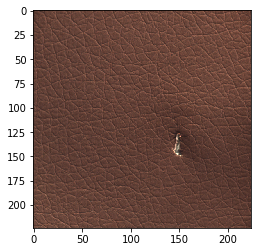

In [50]:
image_path = "/content/drive/My Drive/data/test/defective_leather/leather_cut_007.png"

test_img_load = image.load_img(image_path, target_size=(224,224,3))
plt.imshow(test_img_load)

test_img = image.img_to_array(test_img_load)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

label_map_inv = {v:k  for k,v in labels.items()}

result = saved_model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

In [0]:
CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet',
           'defective_grid','defective_hazelnut','defective_leather','defective_metalnut',
           'defective_pill','defective_screw','defective_tile','defective_toothbrush',
           'defective_transistor','defective_wood','defective_zipper','good_bottle',
           'good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill',
           'good_screw','good_tile','good_toothbrush','good_transistor',
           'good_wood','good_zipper']

In [0]:
# DATASET_ROOT = '/content/drive/My Drive/data/test'

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(DATASET_ROOT,
#                                                     class_mode='categorical',
#                                                     #interpolation='bilinear',
#                                                     target_size=(224, 224),
#                                                     batch_size=1542,
#                                                     shuffle=False,
#                                                     classes=CLASSES)
# unique, counts = np.unique(test_generator.labels, return_counts=True)
# print(dict(zip(CLASSES, counts)))

Found 1542 images belonging to 30 classes.
{'defective_bottle': 19, 'defective_cable': 28, 'defective_capsule': 33, 'defective_carpet': 27, 'defective_grid': 14, 'defective_hazelnut': 21, 'defective_leather': 28, 'defective_metalnut': 28, 'defective_pill': 42, 'defective_screw': 17, 'defective_tile': 25, 'defective_toothbrush': 9, 'defective_transistor': 12, 'defective_wood': 18, 'defective_zipper': 36, 'good_bottle': 69, 'good_cable': 85, 'good_capsule': 73, 'good_carpet': 92, 'good_grid': 86, 'good_hazelnut': 129, 'good_leather': 59, 'good_metalnut': 73, 'good_pill': 88, 'good_screw': 108, 'good_tile': 76, 'good_toothbrush': 3, 'good_transistor': 82, 'good_wood': 80, 'good_zipper': 82}


In [0]:
# test_input,y = test_generator.next()
# print(test_input.shape)

(1542, 224, 224, 3)


In [0]:
# test_defective_leather_idx = np.full(len(test_generator.filenames),False)
 
# for i in range(len(test_generator.filenames)):
#     for j in range(len(test_generator.filenames[i])):
#         if test_generator.filenames[i][j]== "/":
#             break
#     correct_class = test_generator.filenames[i][0:j]
#     if correct_class == "defective_leather":
#         test_defective_leather_idx[i] = True
    

# print(len(test_input[test_defective_leather_idx]))

28


(256, 30)
conv4_block10_1_conv


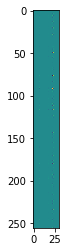

In [81]:
alpha, layer = get_grad_cam_weights(saved_model, np.zeros((1, 224, 224, 3)))

print(alpha.shape)
plt.imshow(alpha)
print(layer)

In [0]:
# saved_model.summary()

In [0]:
Y2 = grad_cam(saved_model, alpha,test_img, np.ones((len(test_img), len(CLASSES))), layer, result,
             orig_sz=test_img.shape[1:3], should_upsample=True)

Text(0.5, 1.0, 'defective_leather')

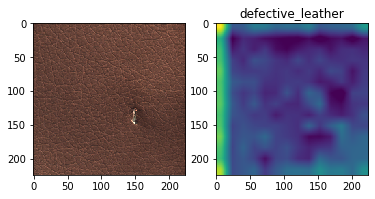

In [83]:
plt.subplot(121)
plt.imshow(test_img_load)
plt.subplot(122)
plt.imshow(Y2[0, :, :, int(prediction)])
plt.title(CLASSES[int(prediction)])